In [1]:
import jax.numpy as jnp

import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt
import tornadox
from matplotlib import animation

import pnmol

from IPython.display import HTML

import jax

In [2]:
# %load_ext autoreload
# %autoreload 2

## Discretize some 1D PDE

In [3]:
discretized_pde = pnmol.pde_problems.heat_1d(tmax=5., dx=0.05, stencil_size=5, diffusion_rate=0.05)
# discretized_pde = pnmol.pde_problems.burgers_1d()

100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 26.39it/s]


In [4]:
constant_steps = tornadox.step.ConstantSteps(0.1)
# adaptive_steps = tornadox.step.AdaptiveSteps(abstol=1e-3, reltol=1e-3)
nu = 2

In [5]:
ek1 = pnmol.solver.MeasurementCovarianceEK1(num_derivatives=nu, steprule=constant_steps)
with jax.disable_jit():
    sol = ek1.solve(ivp=discretized_pde, compile_step=False, progressbar=True)

t=5.0000, dt=1.78E-15: : 101it [00:06, 14.80it/s]                                                          


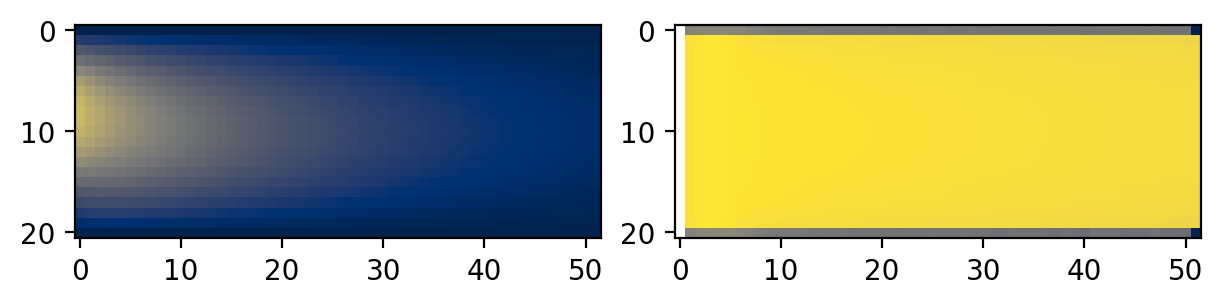

In [6]:
%matplotlib inline

E0 = ek1.iwp.projection_matrix(0)
means = sol.mean[:, 0]
cov = sol.cov_sqrtm @ jnp.transpose(sol.cov_sqrtm, axes=(0,2,1))

stds = jnp.sqrt(jnp.diagonal(cov, axis1=1, axis2=2) @ E0.T)


fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=200, constrained_layout=True)
mean_map = ax1.imshow(means.T, cmap="cividis", vmin=0., vmax=1.)
std_map = ax2.imshow(jnp.log(stds.T), cmap="cividis")
# fig.colorbar(std_map)


In [7]:
plt.rcParams["animation.embed_limit"] = 2 * 10**8  # Set the animation max size to 200MB

grid = discretized_pde.spatial_grid

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1,1,1)
_im1 = ax.plot(grid.points.squeeze(),sol.mean[0, 0])
_im1 = ax.plot(grid.points.squeeze(), discretized_pde.y0.squeeze())

ax1ylim = [-0.2, 1.2]
ax.set_ylim(ax1ylim)

plt.close()


cov = sol.cov_sqrtm @ jnp.transpose(sol.cov_sqrtm, axes=(0,2,1))
def animate(i):
    
    mean = sol.mean[i, 0]
    std = 0 * jnp.sqrt(jnp.diag(cov[i]))[0]
    
    ax.cla()
    ax.set_title(f"t={sol.t[i]}")
    ax.plot(grid.points.squeeze(), mean, color="C0", label="PN solution")
    ax.fill_between(
        grid.points.squeeze(), 
        mean - 2 * std, 
        mean + 2 * std,
        color="C0",
        alpha=0.2,
    )
    ax.set_ylim(ax1ylim)
    ax.legend()
    
# Animation setup
anim = animation.FuncAnimation(
    fig, func=animate, frames=len(sol.t), interval=100, repeat_delay=4000, blit=False
)
HTML(anim.to_jshtml())

In [8]:
anim.save("ek1.gif")